# Multipole model exploration

In [28]:
import h5py
import os
import numpy as np
from tqdm import tqdm

data_dir = "/home/nino/GW/Keras-Project-Template/data/q_multipole"

data = []
files = os.listdir(data_dir)

with h5py.File(os.path.join(data_dir, files[0])) as f20:
    with h5py.File(os.path.join(data_dir, files[0])) as f21:
        with h5py.File(os.path.join(data_dir, files[0])) as f2n2:
            with h5py.File(os.path.join(data_dir, files[0])) as f22:
                with h5py.File(os.path.join(data_dir, files[0])) as f2n1:

                    for w20, w21, w2n2, w22, w2n1 in tqdm(zip(f20["waveforms"][:], f21["waveforms"][:], f2n2["waveforms"][:], f22["waveforms"][:], f2n1["waveforms"][:]), total = 100000):
                        data.append([w22, w21, w20, w2n1, w2n2])

data = np.array(data)
data.shape

bbh_q20_data.hdf5
bbh_q21_data.hdf5
bbh_q2n2_data.hdf5
bbh_q22_data.hdf5
bbh_q2n1_data.hdf5


In [14]:
import keras
from keras import layers
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

inp = keras.Input((5, 2048))

x = layers.Reshape((1, 5, 2048))(inp)
x = layers.Conv2D(filters = 64, kernel_size = (5, 5), strides = (1, 3), activation = "leaky_relu", kernel_initializer = "glorot_uniform", data_format = "channels_first")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'leaky_relu', kernel_initializer = "glorot_uniform")(x)
x = layers.Dense(512, activation = 'leaky_relu', kernel_initializer = "glorot_uniform")(x)

enc = layers.Dense(10)(x)

y = layers.Dense(5*2048, activation="leaky_relu", kernel_initializer = "glorot_uniform")(enc)
opt = layers.Reshape((5, 2048))(y)

multimode_autoencoder = keras.Model(inp, opt)

multimode_autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 5, 2048)]         0         
                                                                 
 reshape_8 (Reshape)         (None, 1, 5, 2048)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 1, 682)        1664      
                                                                 
 flatten_8 (Flatten)         (None, 43648)             0         
                                                                 
 dense_21 (Dense)            (None, 512)               22348288  
                                                                 
 dense_22 (Dense)            (None, 10)                5130      
                                                                 
 dense_23 (Dense)            (None, 10240)             1126

In [30]:
multimode_autoencoder.compile(optimizer = 'adam', loss = 'mae')

multimode_autoencoder.fit(data[:10000], data[:10000], epochs = 200, batch_size = 50)

2024-05-23 18:17:48.836537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:735] failed to allocate 4.48G (4809359360 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-05-23 18:17:48.838836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:735] failed to allocate 4.03G (4328423424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


Epoch 1/200
200/200 [==============================] - 4s 12ms/step - loss: 0.0141
Epoch 2/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0077
Epoch 3/200
200/200 [==============================] - 2s 11ms/step - loss: 0.0064
Epoch 4/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0058
Epoch 5/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0054
Epoch 6/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0052
Epoch 7/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0050
Epoch 8/200
200/200 [==============================] - 3s 13ms/step - loss: 0.0047
Epoch 9/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0045
Epoch 10/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0043
Epoch 11/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0040
Epoch 12/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0038
E

4/4 [==============================] - 0s 14ms/step


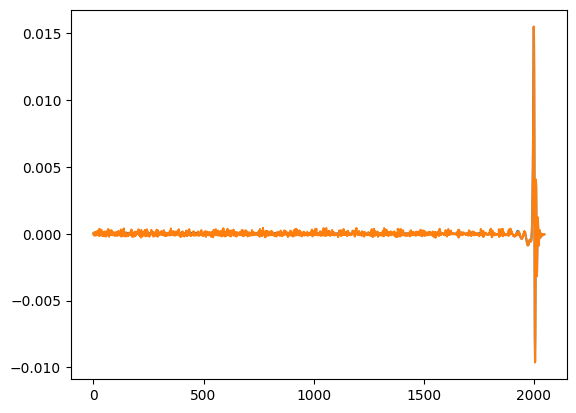

In [26]:
import matplotlib.pyplot as plt

ae_data = multimode_autoencoder.predict(data[:1000], batch_size=256)

plt.plot(data[0, 2])
plt.plot(ae_data[0, 2])

# Model evaluation

In [1]:
import tensorflow as tf
from utils.eval import load_model_and_data_loader
from utils.config import process_config
from utils.plot_utils import *
from data_loader.gw_dataloader import GWDataLoader
import keras

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

model_dir = "/home/nino/GW/Keras-Project-Template/experiments/multipole_q_reg/full_model.hdf5"
config_path = "/home/nino/GW/Keras-Project-Template/experiments/q_bbh_reg_light/reg_q_bbh_light/checkpoints/config.json"
data_folder = "/home/nino/GW/Keras-Project-Template/data/q_multipole"

config, _ = process_config(config_path)
model, data_loader = load_model_and_data_loader("/home/nino/GW/Keras-Project-Template/experiments/q_bbh_reg_light/reg_q_bbh_light/checkpoints")

def define_model(base_model):

    nozz_22 = keras.models.clone_model(keras.Model(base_model.layers[-1].layers[-1].input, base_model.layers[-1].layers[-1].output))
    nozz_21 = keras.models.clone_model(keras.Model(base_model.layers[-1].layers[-2].input, base_model.layers[-1].layers[-1].output))
    nozz_20 = keras.models.clone_model(keras.Model(base_model.layers[-1].layers[-3].input, base_model.layers[-1].layers[-1].output))
    nozz_2n1 = keras.models.clone_model(keras.Model(base_model.layers[-1].layers[-2].input, base_model.layers[-1].layers[-1].output))
    nozz_2n2 = keras.models.clone_model(keras.Model(base_model.layers[-1].layers[-1].input, base_model.layers[-1].layers[-1].output))

    inp = base_model.layers[1].input

    x = base_model.layers[1](inp)
    x = base_model.layers[2](x)

    for layer in base_model.layers[3].layers[:-4]:
        x = layer(x)

    mp20 = base_model.layers[3].layers[-4](x)
    mp21 = base_model.layers[3].layers[-3](mp20)
    mp22 = base_model.layers[3].layers[-2](mp21)

    opt_22 = nozz_22(mp22)
    opt_2n2 = nozz_2n2(mp22)
    opt_21 = nozz_21(mp21)
    opt_2n1 = nozz_2n1(mp21)
    opt_20 = nozz_20(mp20)
    
    return keras.Model(inp, [opt_20, opt_21, opt_2n1, opt_22, opt_2n2])

2024-05-24 16:14:53.153270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 16:14:53.342630: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-24 16:14:54.418191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nino/miniconda3/envs/Tensorflow/lib/
2024-05-24 16:14:54.418307: W tensorflow/co

2024-05-24 16:15:34.250728: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 16:15:35.328889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3174 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5


Loading model checkpoint /home/nino/GW/Keras-Project-Template/experiments/q_bbh_reg_light/reg_q_bbh_light/checkpoints/best_model.hdf5 ...

Model loaded


In [4]:
multimode_model = define_model(model)
multimode_model.load_weights(model_dir)
test_wv = multimode_model.predict(np.array([[1.7, 1.3], [2.5, 1.7]]))

1/1 [==============================] - 0s 225ms/step


In [16]:
np.max(test_wv[0][0])

0.07861644

In [11]:
multimode_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 model_1 (Functional)           (None, 10)           6666        ['input_2[0][0]']                
                                                                                                  
 model (Functional)             (None, 10)           536074      ['model_1[2][0]']                
                                                                                                  
 input_4 (InputLayer)           multiple             0           ['model[2][0]']                  
                                                                                           

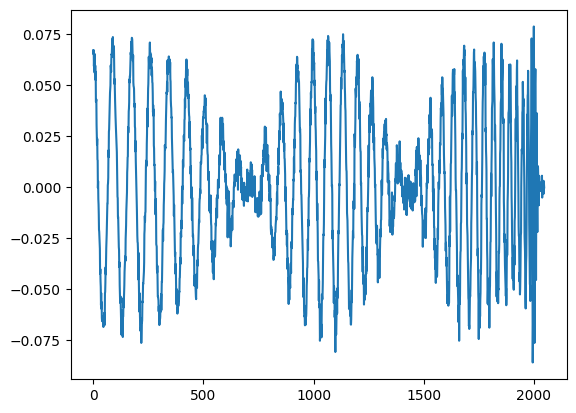

In [9]:
import matplotlib.pyplot as plt

_=plt.plot(test_wv[0][0])

# Keras' overlap loss function

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2024-05-28 13:03:22.536166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 13:03:22.712071: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 13:03:23.663810: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nino/miniconda3/envs/Tensorflow/lib/
2024-05-28 13:03:23.663896: W tensorflow/co

In [6]:
data_loader.__dir__()

['config',
 'train_weights',
 'delta_t',
 'X_train',
 'y_train',
 'X_test',
 'y_test',
 'X',
 'y',
 'in_out_shapes',
 '__module__',
 '__doc__',
 '__init__',
 'get_train_data',
 'get_test_data',
 'get_data',
 '__dict__',
 '__weakref__',
 '__new__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [2]:
from tensorflow.signal import rfft
from keras.losses import mean_absolute_error
import keras.backend as K

def overlap(h1, h2, dt=2*4.925794970773135e-06, df=None):

    split_size = int(4096/2)

    h1_amp, h1_phs = h1[:, :split_size], h1[:, split_size:]
    h2_amp, h2_phs = h2[:, :split_size], h2[:, split_size:]

    h1 =  tf.cast(h1_amp, tf.complex64)*tf.math.exp(1j*(tf.cast(h1_phs, tf.complex64)))
    h2 = tf.cast(h2_amp, tf.complex64)*tf.math.exp(1j*(tf.cast(h2_phs, tf.complex64)))

    h1_f = tf.signal.fft(h1)*dt
    h2_f = tf.signal.fft(h2)*dt
    
    df = 1.0 /  2048 / dt
    sig_norm = 4*df

    sig1 = K.sqrt(tf.cast((tf.math.reduce_sum(tf.math.conj(h1_f)*h1_f,axis=-1)),tf.float32)*sig_norm)
    sig2 = K.sqrt(tf.cast((tf.math.reduce_sum(tf.math.conj(h2_f)*h2_f,axis=-1)),tf.float32)*sig_norm)
    
    norm = 1/sig1/sig2
    inner = tf.cast(tf.math.reduce_sum((tf.math.conj(h1_f)*h2_f),axis=-1),tf.float32)
    overl = tf.cast((4*df*inner*norm),tf.float32)
    
    return  K.abs(1. - overl)

def ovlp_mae_loss(y_pred, y_true):
    
    return overlap(y_pred, y_true) + mean_absolute_error(y_pred, y_true)

In [3]:
import keras
from keras import layers
import h5py
import numpy as np
from data_loader.gw_dataloader import GWDataLoader
from utils.config import get_config_from_json

config, _ = get_config_from_json("/home/nino/GW/Keras-Project-Template/configs/gw_reg_ae_config.json")
config.data_loader.data_output_type = "amplitude_phase"
data_loader =  GWDataLoader(config)

inp = keras.Input(data_loader.in_out_shapes['input_shape'])
x = layers.Dense(1024, activation='leaky_relu')(inp)
x = layers.Dense(1024, activation='leaky_relu')(x)
x = layers.Dense(1024, activation='leaky_relu')(x)
x = layers.Dense(1024, activation='leaky_relu')(x)
opt = layers.Dense(data_loader.in_out_shapes['output_shape'])(x)

model = keras.Model(inp, opt)

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-6), metrics = [overlap, mean_absolute_error], loss = ovlp_mae_loss)

2024-05-28 13:03:49.966366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 13:03:51.123349: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9884 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [4]:
model.fit(data_loader.get_train_data() , validation_data = data_loader.get_test_data(), epochs = 300, batch_size = 64)

Epoch 1/300
1639/1639 [==============================] - 15s 7ms/step - loss: 44.4915 - overlap: 0.8435 - mean_absolute_error: 43.6479 - val_loss: 44.4179 - val_overlap: 0.7703 - val_mean_absolute_error: 43.6476
Epoch 2/300
1639/1639 [==============================] - 11s 7ms/step - loss: 44.3873 - overlap: 0.7425 - mean_absolute_error: 43.6447 - val_loss: 44.3640 - val_overlap: 0.7194 - val_mean_absolute_error: 43.6446
Epoch 3/300
1639/1639 [==============================] - 17s 10ms/step - loss: 44.3455 - overlap: 0.7046 - mean_absolute_error: 43.6410 - val_loss: 44.3317 - val_overlap: 0.6919 - val_mean_absolute_error: 43.6398
Epoch 4/300
1639/1639 [==============================] - 17s 10ms/step - loss: 44.3150 - overlap: 0.6804 - mean_absolute_error: 43.6346 - val_loss: 44.3003 - val_overlap: 0.6687 - val_mean_absolute_error: 43.6317
Epoch 5/300
1639/1639 [==============================] - 17s 10ms/step - loss: 44.2812 - overlap: 0.6575 - mean_absolute_error: 43.6237 - val_loss: 44

KeyboardInterrupt: 

20/20 [==============================] - 0s 4ms/step


Calculating mismatches: 100%|██████████| 10000/10000 [02:12<00:00, 75.20it/s]
/home/nino/miniconda3/envs/Tensorflow/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


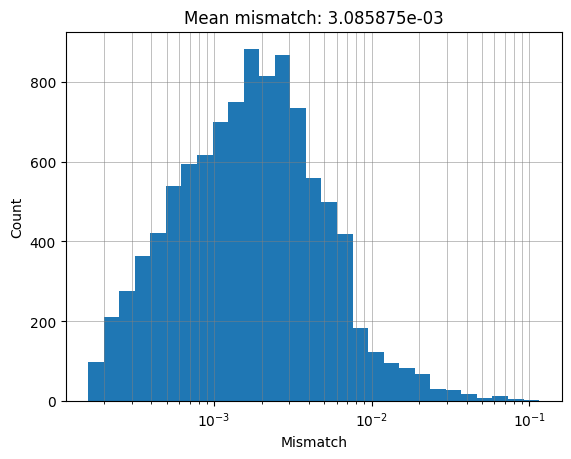

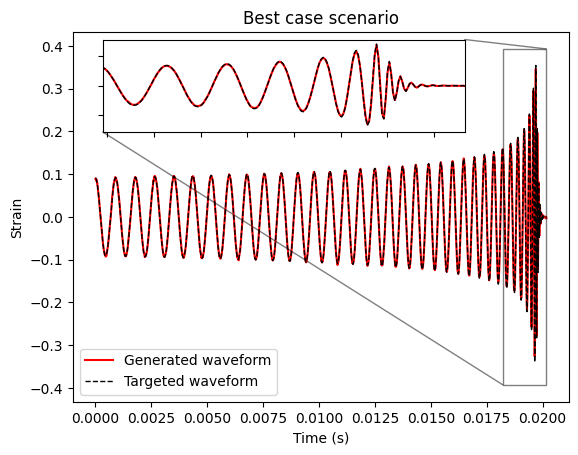

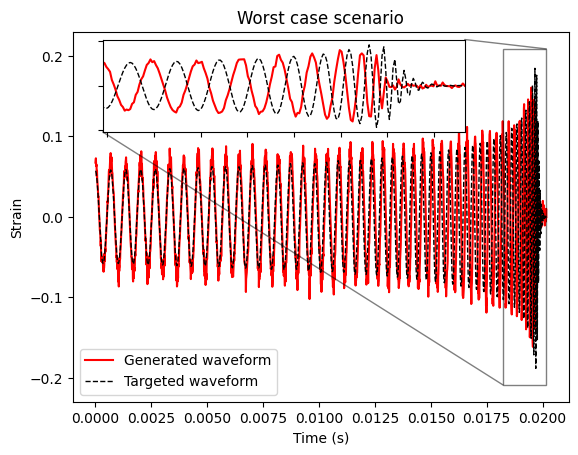

In [8]:
from utils.plot_utils import nb_evaluate_model
import numpy as np

y_pred = model.predict(data_loader.X_test, batch_size = 1024)
y = []
grd = []

for wv, grd_wv in zip(y_pred, data_loader.y_test):
    amp = wv[:2048]
    phs = wv[2048:]

    grd_amp = grd_wv[:2048]
    grd_phs = grd_wv[2048:]

    grd.append(grd_amp*np.exp(1.0j*grd_phs))
    y.append(amp*np.exp(1.0j*phs))

y_pred = np.array(y)
y_true = np.array(grd)

nb_evaluate_model(y_pred[:10000], y_true[:10000], data_loader.delta_t)


In [2]:
from utils.eval import load_model_and_data_loader

model, data_loader = load_model_and_data_loader("/home/nino/GW/Keras-Project-Template/experiments/osv_qz_ovlp_light/reg_q_bbh_light/checkpoints")

/home/nino/miniconda3/envs/Tensorflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-05-28 11:26:21.552789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 11:26:22.739306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8820 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5


Loading model checkpoint /home/nino/GW/Keras-Project-Template/experiments/osv_qz_ovlp_light/reg_q_bbh_light/checkpoints/best_model.hdf5 ...



ValueError: Weight count mismatch for layer #0 (named model_1 in the current model, model_1 in the save file). Layer expects 6 weight(s). Received 4 saved weight(s)

In [9]:
y_pred = model.predict(data_loader.X_test, batch_size = 1024)

mae_ts = mean_absolute_error(y_pred, data_loader.y_test)
ovlp_ts = overlap(y_pred, data_loader.y_test)

20/20 [==============================] - 0s 2ms/step


In [16]:
print(f"Mean abs error:   {np.mean(mae_ts.numpy()):.4f}\nMean 1 - Overlap: {np.mean(ovlp_ts.numpy()):.4f}")

Mean abs error:   0.0204
Mean 1 - Overlap: 0.6946


In [ ]:
import keras.optimizers
from keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss = 'mae', metrics = [overlap])
callbacks = [ReduceLROnPlateau(monitor='loss', factor=0.5, patience=15)]

model.fit(data_loader.get_generator_train_data(), validation_data=data_loader.get_generator_test_data(), epochs = 1000, batch_size = 50, callbacks=callbacks)

20/20 [==============================] - 0s 2ms/step


Calculating mismatches: 100%|██████████| 1000/1000 [00:13<00:00, 73.41it/s]


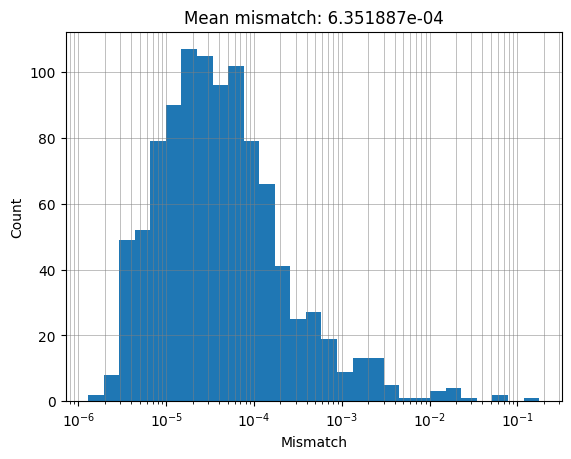

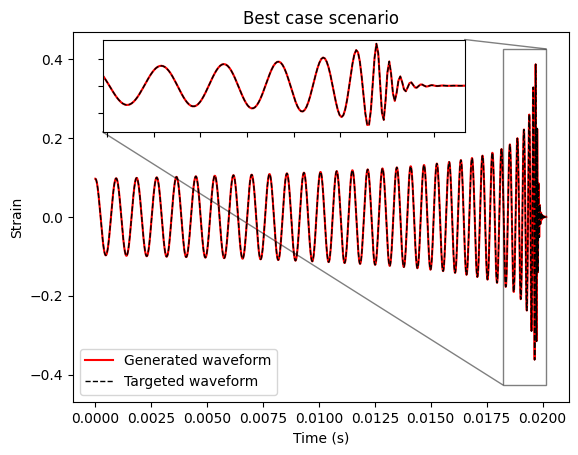

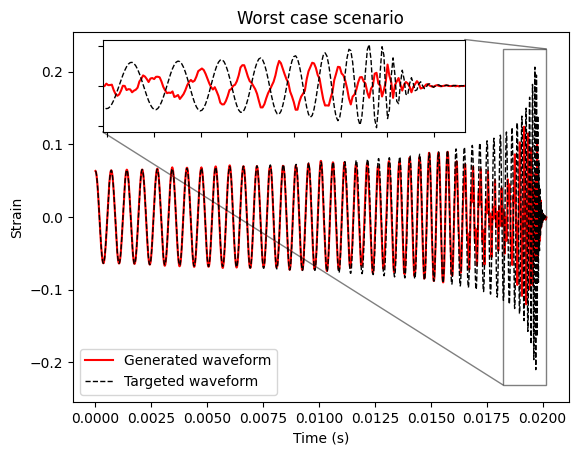

In [27]:
from utils.plot_utils import nb_evaluate_model

y_pred_ts = model.predict(data_loader.X_test, batch_size=1024)

nb_evaluate_model(y_pred_ts, data_loader, data_loader.delta_t)

# Dense vs. reg ae

In [1]:
import keras
from keras import layers
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

inp = keras.Input(3)

x = layers.Dense(1024, activation = 'leaky_relu', kernel_initializer = 'glorot_uniform')(inp)
x = layers.Dense(1024, activation = 'leaky_relu', kernel_initializer = 'glorot_uniform')(x)
x = layers.Dense(1024, activation = 'leaky_relu', kernel_initializer = 'glorot_uniform')(x)
x = layers.Dense(1024, activation = 'leaky_relu', kernel_initializer = 'glorot_uniform')(x)
x = layers.Dense(512, activation = 'leaky_relu', kernel_initializer = 'glorot_uniform')(x)

opt = layers.Dense(4096)(x)

dense_model = keras.Model(inp, opt)

2024-06-05 07:34:21.855791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 07:34:22.890317: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22824 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5


# NR transfer learning

In [1]:
import tensorflow as tf
from utils.eval import load_model_and_data_loader
from utils.config import process_config
from utils.plot_utils import *
import os

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

model_dir = "/home/nino/GW/Keras-Project-Template/experiments/osv_amp_phs_overlap/reg_q_bbh_light/checkpoints"
config_path = os.path.join(model_dir, "config.json")

config, _ = process_config(config_path)
model, data_loader = load_model_and_data_loader(model_dir)

model.load_weights("/home/nino/GW/Keras-Project-Template/experiments/osv_amp_phs_overlap/reg_q_bbh_light/checkpoints/tl_weights.hdf5")

2024-06-10 09:10:30.134625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 09:10:30.401879: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 09:10:31.708173: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nino/miniconda3/envs/Tensorflow/lib/
2024-06-10 09:10:31.708373: W tensorflow/co

2024-06-10 09:11:06.770955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 09:11:08.064532: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17082 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5


Loading model checkpoint /home/nino/GW/Keras-Project-Template/experiments/osv_amp_phs_overlap/reg_q_bbh_light/checkpoints/best_model.hdf5 ...

Model loaded


In [2]:
import pandas as pd
from utils.data_preprocessing import get_phases

nr_data = pd.read_pickle("/home/nino/GW/Keras-Project-Template/data/datasets_osv_14-05.pkl")

waveforms_tr = np.concatenate([np.abs(nr_data['train'][:][0]), -get_phases(nr_data['train'][:][0])], axis = 1)
pars_tr = nr_data['train'][1][:, :3]
pars_tr[:, 0] = 1/nr_data['train'][1][:, 0]
waveforms_val = np.concatenate([np.abs(nr_data['valid'][:][0]), -get_phases(nr_data['valid'][:][0])], axis = 1)
pars_val = nr_data['valid'][1][:, :3]
pars_val[:, 0] = 1/nr_data['valid'][1][:, 0]
waveforms_ts = np.concatenate([np.abs(nr_data['test'][:][0]), -get_phases(nr_data['test'][:][0])], axis = 1)
pars_ts = nr_data['test'][1][:, :3]
pars_ts[:, 0] = 1/nr_data['test'][1][:, 0]

In [35]:
for in_model in model.layers[1:]:
    for layer in in_model.layers:
        layer.trainable = False

model.layers[-1].layers[-1].trainable = True

In [4]:
import keras.optimizers
from utils.loss import ovlp_mae_loss, overlap
from keras.losses import mean_absolute_error
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

adam = keras.optimizers.Adam(learning_rate = 1e-6)

es = EarlyStopping(monitor = 'val_loss', patience = 15, min_delta = 1e-6)
rl = ReduceLROnPlateau(monitor = 'loss', factor = 0.5, patience = 10, verbose = 1, min_lr = 1e-9, cooldown = 3)

callbacks = [es, rl]

model.compile(optimizer = adam, loss = ovlp_mae_loss, metrics = [overlap, mean_absolute_error])

In [5]:
model.fit(x = pars_tr, y = waveforms_tr, validation_data = (pars_val, waveforms_val), epochs = 1000, callbacks = callbacks)

Epoch 1/1000
6/6 [==============================] - 3s 96ms/step - loss: 0.0956 - overlap: 0.0365 - mean_absolute_error: 0.0591 - val_loss: 0.0791 - val_overlap: 0.0241 - val_mean_absolute_error: 0.0550 - lr: 1.0000e-06
Epoch 2/1000
6/6 [==============================] - 0s 23ms/step - loss: 0.0855 - overlap: 0.0318 - mean_absolute_error: 0.0537 - val_loss: 0.0755 - val_overlap: 0.0233 - val_mean_absolute_error: 0.0522 - lr: 1.0000e-06
Epoch 3/1000
6/6 [==============================] - 0s 23ms/step - loss: 0.0828 - overlap: 0.0304 - mean_absolute_error: 0.0524 - val_loss: 0.0752 - val_overlap: 0.0231 - val_mean_absolute_error: 0.0521 - lr: 1.0000e-06
Epoch 4/1000
6/6 [==============================] - 0s 22ms/step - loss: 0.0798 - overlap: 0.0289 - mean_absolute_error: 0.0509 - val_loss: 0.0754 - val_overlap: 0.0235 - val_mean_absolute_error: 0.0519 - lr: 1.0000e-06
Epoch 5/1000
6/6 [==============================] - 0s 23ms/step - loss: 0.0762 - overlap: 0.0276 - mean_absolute_error:

In [3]:
import numpy as np

def get_waveforms(amp_phs):

    total = len(amp_phs[0])
    split_idx = int(total/2)

    wvs = []

    for dt in amp_phs:

        re = dt[:split_idx] * np.cos(dt[split_idx:])
        im = dt[:split_idx] * np.sin(dt[split_idx:])

        wvs.append(re + 1.0j*im)
    
    return np.array(wvs)

In [4]:
pred_ts = model.predict(pars_ts)
pred_tr = model.predict(pars_tr)
pred_val = model.predict(pars_val)

5/5 [==============================] - 0s 4ms/step


Calculating mismatches:  19%|█▉        | 9/48 [00:00<00:02, 15.85it/s]

Calculating mismatches: 100%|██████████| 48/48 [00:02<00:00, 18.39it/s]
/home/nino/miniconda3/envs/Tensorflow/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


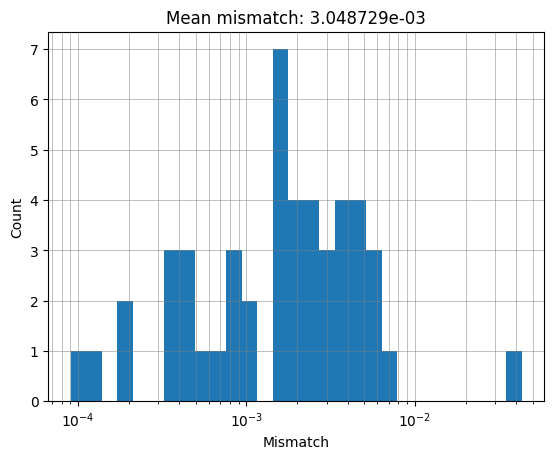

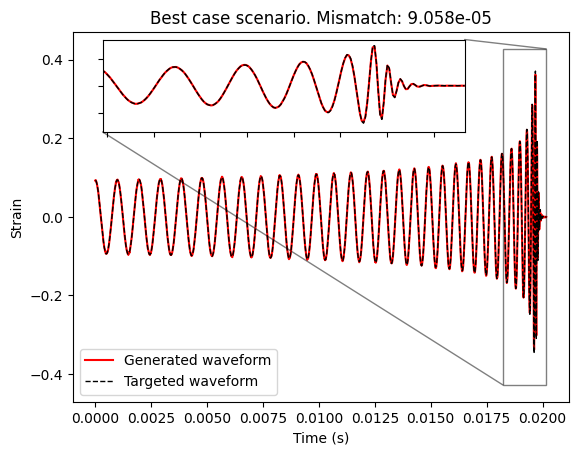

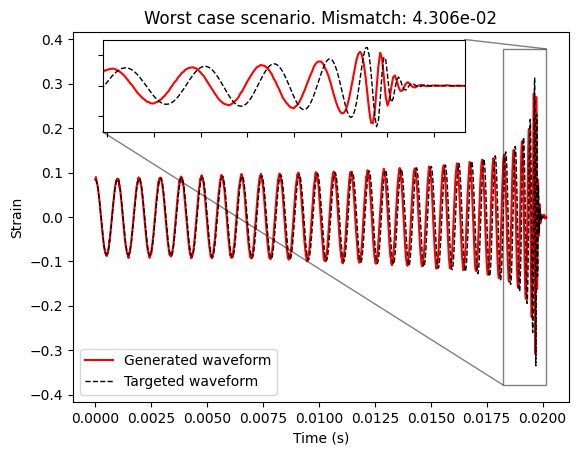

In [5]:
from utils.plot_utils import nb_evaluate_model

nb_evaluate_model(y_pred = get_waveforms(pred_ts), y_true = get_waveforms(waveforms_ts), delta_t = data_loader.delta_t)
# nb_evaluate_model(y_pred = get_waveforms(pred_tr), y_true = get_waveforms(waveforms_tr), delta_t = data_loader.delta_t)
# nb_evaluate_model(y_pred = get_waveforms(pred_val), y_true = get_waveforms(waveforms_val), delta_t = data_loader.delta_t)

In [29]:
from utils.config import get_config_from_json
from data_loader.gw_dataloader import GWDataLoader

config, _ = get_config_from_json("/home/nino/GW/Keras-Project-Template/experiments/osv_amp_phs_overlap/reg_q_bbh_light/checkpoints/config.json")
data_loader = GWDataLoader(config)

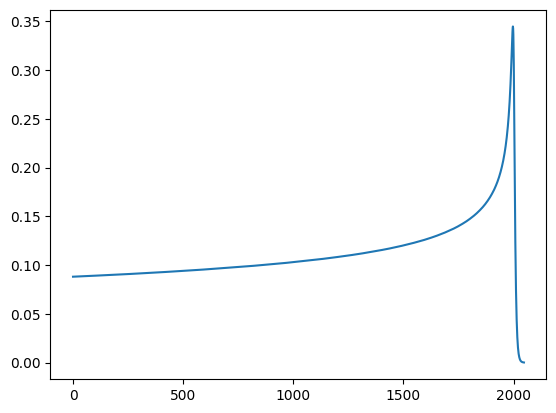

In [31]:
import matplotlib.pyplot as plt

plt.plot(waveforms_tr[0][:2048])
# plt.plot(data_loader.y_train[0][:2048])

In [6]:
import h5py

f = h5py.File("/home/nino/GW/Keras-Project-Template/data/bbh_q_data.hdf5")
f['parameters'][:]

array([[63.23869338, 36.76130662],
       [74.04706389, 25.95293611],
       [56.87079338, 43.12920662],
       ...,
       [68.78175797, 31.21824203],
       [50.90285059, 49.09714941],
       [70.86292917, 29.13707083]])

# GW surrogate

In [15]:
import gwsurrogate

sur = gwsurrogate.LoadSurrogate('NRHybSur3dq8')

q = 2.1
z1 = 0.3
z2 = -0.1
M_sun = 1.9885e30
c = 299792458
G = 6.67430e-11
f_low = 5e-3
delta_t = 2

delta_t_seconds = delta_t*G*M_sun/(c**3)

_, h, _ = sur(q, [0, 0, z1], [0, 0, z2], dt=delta_t, f_low=f_low)

Loaded NRHybSur3dq8 model


/home/nino/miniconda3/envs/gw_surrogate/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


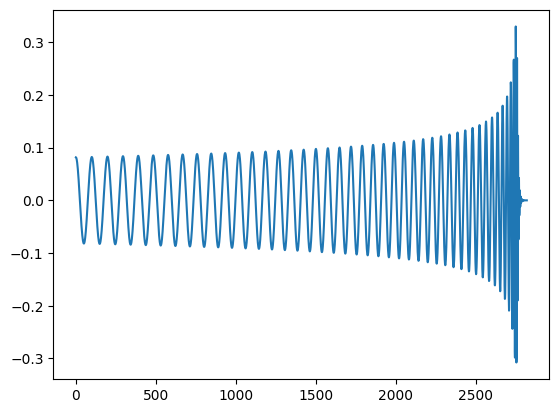

In [16]:
import matplotlib.pyplot as plt

plt.plot(h[(2, 2)])

In [1]:
import h5py
import pandas as pd

f_sxs = h5py.File("/home/nino/GW/Keras-Project-Template/data/sxs_qz_data.hdf5")
# f_sur = h5py.File("/home/nino/GW/Keras-Project-Template/data/bbh_q_data.hdf5")

In [3]:
pd.DataFrame(f_sxs['parameters'][:]).describe()

,0,1,2,3,4,5,6
count,397.000000,3.970000e+02,3.970000e+02,397.000000,3.970000e+02,3.970000e+02,397.000000
mean,2.020800,-7.957249e-02,-6.387857e-02,0.004402,-8.227146e-02,-6.411650e-02,0.024526
std,0.896474,1.955904e-01,1.577468e-01,0.448965,1.962964e-01,1.595967e-01,0.503615
min,0.999910,-7.974814e-01,-7.957796e-01,-0.799967,-7.994725e-01,-7.339225e-01,-0.799890
25%,1.172529,-8.458232e-07,-5.892312e-07,-0.399785,-2.902755e-07,-4.440325e-07,-0.399960
50%,1.999694,-1.866192e-08,-2.011296e-08,0.000023,-5.645374e-09,-6.532546e-09,0.000025
75%,2.999295,3.989212e-08,2.884423e-08,0.399964,3.188916e-08,2.217977e-08,0.457042
max,3.999947,9.371907e-03,8.934558e-03,0.799997,9.617914e-03,5.547693e-03,0.799998


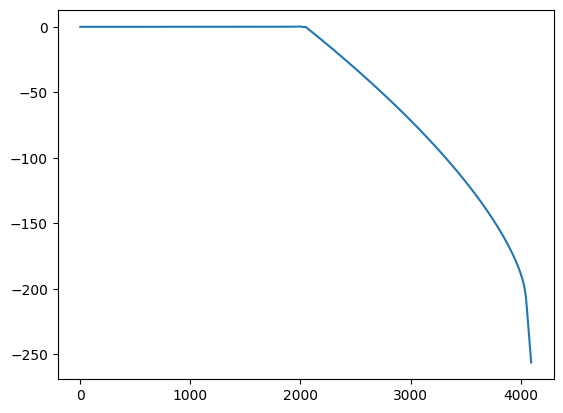

In [13]:
import matplotlib.pyplot as plt
from utils.data_preprocessing import load_data

sxs_pars, sxs_data, _ = load_data("./data/sxs_q_data.hdf5", "amplitude_phase")
sur_pars, sur_data, _ = load_data("./data/bbh_q_data.hdf5", "amplitude_phase")

plt.plot(sur_data[0])

In [ ]:
from models.gw_models import RegularizedAutoEncoderGenerator

(array([164., 132.,  79.,  86.,  67.,  62.,  75.,  93.,  99., 143.]),
 array([1.0028672 , 1.90175164, 2.80063608, 3.69952052, 4.59840496,
        5.49728939, 6.39617383, 7.29505827, 8.19394271, 9.09282715,
        9.99171159]),
 <BarContainer object of 10 artists>)

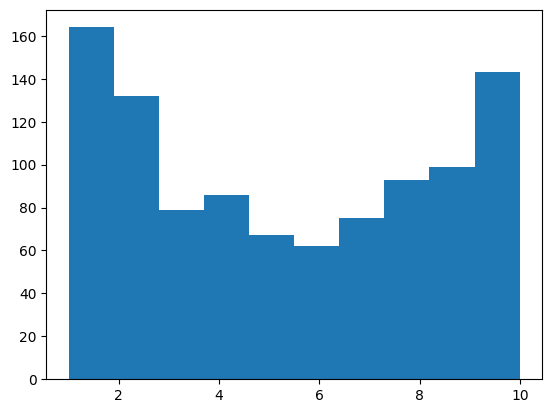

In [2]:
import numpy as np

def get_q():

    qs = np.random.uniform(1, 10, 5)
    p = np.random.uniform(0, 1, 1)

    if p < 0.3:
        
        q = np.min(qs)
    elif 0.3 <= p < 0.8:
        
        q = qs[0]
    elif 0.8 <= p:

        q = np.max(qs)

    return q

q = []

for i in range(1000):
    q.append(get_q())

import matplotlib.pyplot as plt

plt.hist(q)

In [16]:
import h5py

f = h5py.File("/home/nino/GW/Keras-Project-Template/data/bbh_hyb_qz_data.hdf5")
len(f['waveforms'][:])

10

In [17]:
len(f['parameters'][:])

10

In [20]:
import gwsurrogate

gwsurrogate.catalog.list()

EOBNRv2
SpEC_q1_10_NoSpin
SpEC_q1_10_NoSpin_linear
SpEC_q1_10_NoSpin_linear_alt
NRSur4d2s_TDROM_grid12
NRSur4d2s_FDROM_grid12
NRHybSur3dq8
NRHybSur3dq8_CCE
NRHybSur2dq15
NRSur7dq4
NRHybSur3dq8Tidal
EMRISur1dq1e4
BHPTNRSur1dq1e4


In [14]:
import gwsurrogate

sur = gwsurrogate.LoadSurrogate('NRHybSur3dq8')

margin = 500
f_low = 5e-3
delta_t = 2
N = 10
wave_length = 2048
zeros = np.zeros(N)


q, s1, s2 = [6.2, 0.5, 0.5]
_, h, _ = sur(q, [0, 0, s1], [0, 0, s2], dt=delta_t, f_low=f_low)
proc = process_data(np.real(h[(2, 2)]), np.imag(h[(2, 2)]), margin, wave_length)
len(proc[0])

Loaded NRHybSur3dq8 model


2048

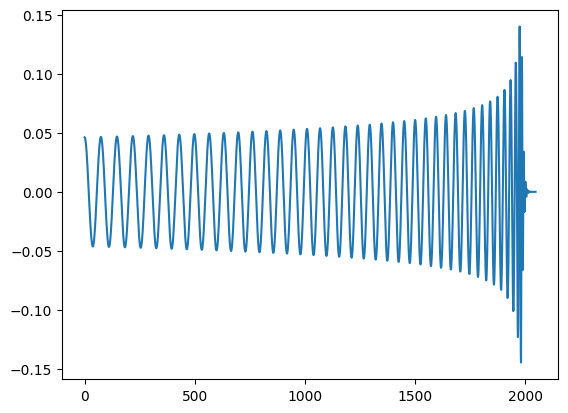

In [19]:
import matplotlib.pyplot as plt

plt.plot(f['waveforms'][5])

In [1]:
import h5py

f = h5py.File("/home/nino/GW/Keras-Project-Template/data/bbh_hyb_qz_data.hdf5")
len(f['waveforms'][:])

100000

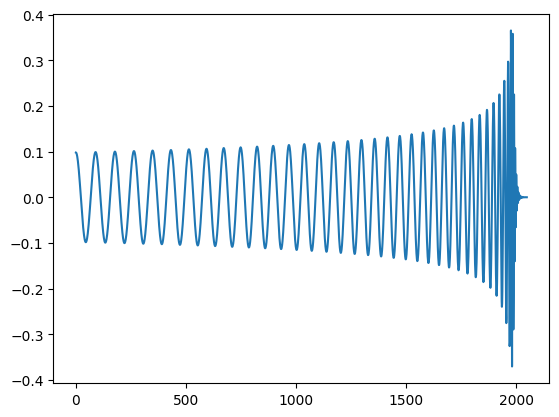

In [10]:
import matplotlib.pyplot as plt


plt.plot(f['waveforms'][80000])

# Initialization comparison

## Regularized autoencoder

In [2]:
import joblib
import os
import pandas as pd
import matplotlib.pyplot as plt

path = "/home/nino/GW/Keras-Project-Template/experiments/2024-07-09_11-22-17/reg_qz_bbh/checkpoints"
path_ae = os.path.join(path, "history_autoencoder.bin")
path_emb = os.path.join(path, "history_embdedder.bin")
path_gen = os.path.join(path, "history_generator.bin")
path_map = os.path.join(path, "history_mapper.bin")

h_ae = joblib.load(path_ae)
h_emb = joblib.load(path_emb)
h_gen = joblib.load(path_gen)
h_map = joblib.load(path_map)

In [15]:
pd.DataFrame(h_ae).iloc[-1]

loss                       9.054909e-04
encoding_loss              7.168227e-02
reconstruction_loss        1.905735e-04
val_loss                   9.964537e-04
val_encoding_loss          7.848682e-02
val_reconstruction_loss    2.137227e-04
lr                         1.024000e-11
Name: 300, dtype: float64

In [17]:
pd.DataFrame(h_map).iloc[-1]

loss        2.844274e-02
val_loss    3.613024e-02
lr          1.000000e-11
Name: 411, dtype: float64

In [16]:
pd.DataFrame(h_gen).iloc[-1]

loss                       8.343564e-04
overlap_hphc               1.605293e-04
mean_absolute_error        6.738270e-04
val_loss                   8.343745e-04
val_overlap_hphc           1.605479e-04
val_mean_absolute_error    6.738264e-04
lr                         1.000000e-11
Name: 210, dtype: float64

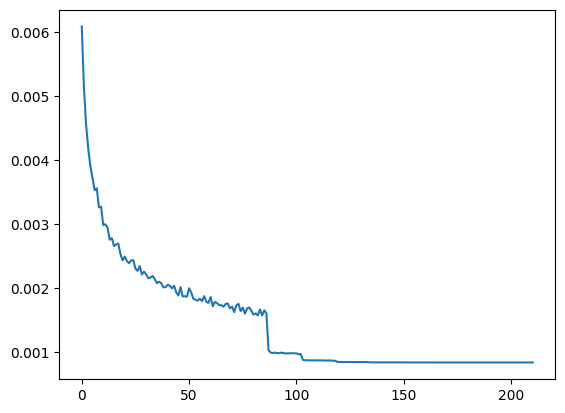

In [7]:
plt.plot(h_gen['loss'])

In [1]:
from utils.eval import load_model_and_data_loader

model, data_loader = load_model_and_data_loader("/home/nino/GW/Keras-Project-Template/experiments/2024-07-09_11-22-17/reg_qz_bbh/checkpoints")

/home/nino/miniconda3/envs/Tensorflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-07-10 07:35:02.722813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 07:35:03.524552: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21505 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5


Loading model checkpoint /home/nino/GW/Keras-Project-Template/experiments/2024-07-09_11-22-17/reg_qz_bbh/checkpoints/best_model.hdf5 ...

Model loaded


In [2]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3)]               0         
                                                                 
 model_1 (Functional)        (None, 10)                269834    
                                                                 
 model (Functional)          (None, 10)                803850    
                                                                 
 model_4 (Functional)        (None, 4096)              6308864   
                                                                 
Total params: 7,382,548
Trainable params: 7,382,548
Non-trainable params: 0
_________________________________________________________________


## Mapped architecture uninitialized

In [ ]:
import joblib
import os
import pandas as pd
import matplotlib.pyplot as plt

path = "/home/nino/GW/Keras-Project-Template/experiments/2024-07-09_13-40-58/no_init_mapped_qzp_bbh/checkpoints/history.bin"
hist = joblib.load(path)

In [20]:
pd.DataFrame(hist.history).iloc[-1]

loss                       2.994510e-04
overlap_hphc               2.243329e-05
mean_absolute_error        2.770175e-04
val_loss                   3.213063e-04
val_overlap_hphc           2.527131e-05
val_mean_absolute_error    2.960350e-04
lr                         3.051758e-09
Name: 303, dtype: float64

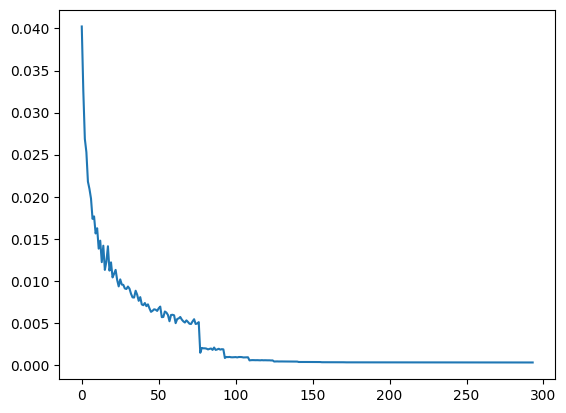

In [22]:
plt.plot(hist.history['loss'][10:])

In [35]:
hist.model.layers[2].summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_9 (Dense)             (None, 1024)              11264     
                                                                 
 dense_10 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_11 (Dense)            (None, 1024)              1049600   
                                                                 
 reconstruction (Dense)      (None, 4096)              4198400   
                                                                 
Total params: 6,308,864
Trainable params: 6,308,864
Non-trainable params: 0
_________________________________________________________________


## Regularized architecture uninitialized

In [4]:
import joblib
import os
import pandas as pd
import matplotlib.pyplot as plt

path = "/home/nino/GW/Keras-Project-Template/experiments/2024-07-09_12-47-14/gw_no_init_qz_bbh/checkpoints/history.bin"
hist = joblib.load(path)

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2024-07-09 13:40:48     29594176
config.json                                    2024-07-09 13:40:48         9130
metadata.json                                  2024-07-09 13:40:48           64


Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......functional
.........layers
............dense
...............vars
..................0
..................1
............dense_1
...............vars
..................0
..................1
............dense_2
...............vars
..................0
..................1
............input_layer
...............vars
.........vars
......functional_1
.........layers
............add
...............vars
............concatenate
...............vars
............dense
...............vars
..................0
..................1
............dense_1
...............vars
..................0
..................1
............dense_2
...............vars
..................0
..................1
............dense_3
...............vars
..................0
..................1
............dense_4
...............vars
..................0
..................1
............input_layer
...............vars
.........vars
......functional_2
.....

In [5]:
pd.DataFrame(hist.history).iloc[-1]

loss                       2.749629e-04
overlap_hphc               1.860404e-05
mean_absolute_error        2.563590e-04
val_loss                   3.065580e-04
val_overlap_hphc           2.272545e-05
val_mean_absolute_error    2.838326e-04
lr                         3.051758e-09
Name: 375, dtype: float64

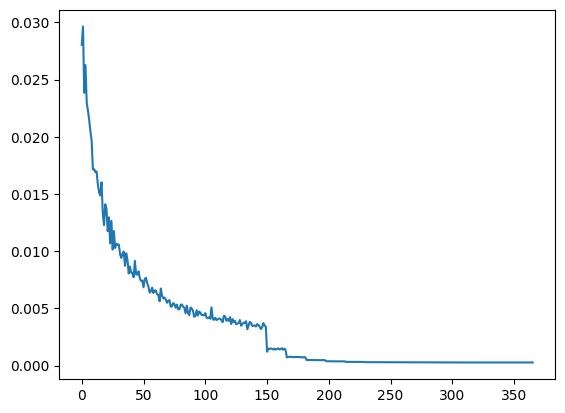

In [6]:
plt.plot(hist.history['loss'][10:])

In [8]:
hist.model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3)]               0         
                                                                 
 model_1 (Functional)        (None, 10)                269834    
                                                                 
 model (Functional)          (None, 10)                803850    
                                                                 
 model_4 (Functional)        (None, 4096)              6308864   
                                                                 
Total params: 7,382,548
Trainable params: 7,382,548
Non-trainable params: 0
_________________________________________________________________


# Embedding exploration

In [2]:
import tensorflow as tf
from utils.eval import load_model_and_data_loader

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

model_dir_no_init = "/home/nino/GW/Keras-Project-Template/experiments/no_init_hphc_mae/gw_no_init_qz_bbh/checkpoints"
model_dir_reg = "/home/nino/GW/Keras-Project-Template/experiments/reg_hphc_mae/reg_qz_bbh/checkpoints"

model_no_init, data_loader_1 = load_model_and_data_loader(model_dir_no_init)
model_reg, data_loader_2 = load_model_and_data_loader(model_dir_reg)

2024-07-15 09:53:35.765509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 09:53:36.579078: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21505 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5


Loading model checkpoint /home/nino/GW/Keras-Project-Template/experiments/no_init_hphc_mae/gw_no_init_qz_bbh/checkpoints/best_model.hdf5 ...

Model loaded
Loading model checkpoint /home/nino/GW/Keras-Project-Template/experiments/reg_hphc_mae/reg_qz_bbh/checkpoints/best_model.hdf5 ...

Model loaded


In [7]:
model_no_init.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3)]               0         
                                                                 
 model_1 (Functional)        (None, 10)                269834    
                                                                 
 model (Functional)          (None, 10)                803850    
                                                                 
 model_4 (Functional)        (None, 4096)              6308864   
                                                                 
Total params: 7,382,548
Trainable params: 7,382,548
Non-trainable params: 0
_________________________________________________________________


In [10]:
emb_no_init_1 = model_no_init.layers[1](data_loader_1.X_train).numpy()
emb_no_init_2 = model_no_init.layers[2](model_no_init.layers[1](data_loader_1.X_train)).numpy()

emb_reg_1 = model_reg.layers[1](data_loader_1.X_train).numpy()
emb_reg_2 = model_reg.layers[2](model_no_init.layers[1](data_loader_1.X_train)).numpy()

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(emb_no_init_1).describe()

,0,1,2,3,4,5,6,7,8,9
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,0.178051,-0.145869,0.135848,-0.029942,0.153318,-0.025889,0.126818,-0.103094,-0.115973,-0.095124
std,0.108773,0.206891,0.196304,0.478867,0.108976,0.360775,0.147502,0.078609,0.257364,0.351621
min,-0.418138,-0.653599,-0.369293,-1.705425,-0.215780,-0.961025,-0.660992,-0.229988,-0.692855,-1.094661
25%,0.119708,-0.289093,-0.015297,-0.367014,0.081000,-0.279841,0.082257,-0.162163,-0.311007,-0.344473
50%,0.206524,-0.169980,0.095902,0.035075,0.189118,-0.021857,0.161547,-0.125953,-0.126397,-0.093921
75%,0.257288,-0.022848,0.260482,0.335155,0.239626,0.218156,0.222503,-0.065861,0.058177,0.156831
max,0.432130,0.506603,0.787089,0.967241,0.310571,1.093810,0.362340,0.302593,0.733571,0.854896


In [14]:
pd.DataFrame(emb_no_init_2).describe()

,0,1,2,3,4,5,6,7,8,9
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,-0.151905,0.020647,0.093424,-0.163048,0.008531,-0.114394,-0.103028,0.153637,-0.058893,0.000793
std,0.524078,0.181002,0.242502,0.538308,0.277576,0.318641,0.400733,0.461233,0.217304,0.348407
min,-3.653215,-0.312736,-0.423828,-1.300048,-0.781620,-0.972574,-0.922288,-0.435654,-0.765020,-1.996634
25%,-0.345244,-0.089026,-0.113071,-0.526576,-0.194359,-0.302261,-0.437282,-0.177719,-0.178945,-0.269002
50%,-0.061949,-0.010673,0.085545,-0.260294,0.018682,-0.069693,-0.122034,0.039277,0.007492,-0.061642
75%,0.199940,0.070072,0.293085,0.321299,0.222617,0.103735,0.241412,0.331890,0.077425,0.212428
max,0.477400,0.813257,0.960883,1.319307,1.497235,0.562837,0.854300,1.582337,0.958243,0.850276


In [16]:
pd.DataFrame(emb_reg_1).describe()

,0,1,2,3,4,5,6,7,8,9
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,8.322225,-7.419222,-1.764048,0.878938,-4.837265,-0.632986,4.949587,7.317740,-0.156551,-2.701470
std,6.163819,3.875112,4.527863,4.447240,2.299117,3.242027,2.606693,4.943159,1.580858,2.533873
min,-5.496858,-15.966196,-14.557944,-11.037464,-10.537804,-8.124115,-1.383808,-3.960110,-4.191595,-8.142976
25%,3.190260,-10.605752,-5.025957,-2.324471,-6.598686,-3.017895,2.941388,3.253605,-1.363099,-4.796131
50%,8.200998,-7.391618,-1.718083,0.821338,-4.812541,-0.646004,4.924492,7.239287,-0.154270,-2.704616
75%,13.379201,-4.224209,1.532717,4.023187,-3.053181,1.716568,6.944994,11.307635,1.041950,-0.598174
max,22.116365,1.392386,10.160227,13.752610,0.978702,7.125256,11.356055,19.289154,4.016608,2.710573


In [17]:
pd.DataFrame(emb_reg_2).describe()

,0,1,2,3,4,5,6,7,8,9
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,0.336920,0.117568,0.219748,-0.112121,0.324480,-0.109559,-0.211982,-0.357383,-0.335457,-0.051596
std,0.169112,0.157060,0.188774,0.444282,0.140382,0.326525,0.150413,0.129933,0.253579,0.342339
min,-0.084719,-0.702892,-0.226313,-1.627449,-0.281443,-0.712731,-1.012527,-0.646524,-1.021361,-1.284756
25%,0.224905,0.021041,0.072309,-0.405713,0.241474,-0.387620,-0.264610,-0.429878,-0.530990,-0.277652
50%,0.370479,0.145960,0.189929,-0.061468,0.357407,-0.135157,-0.177905,-0.397800,-0.345183,-0.031241
75%,0.477425,0.218811,0.339693,0.244694,0.436260,0.140512,-0.109949,-0.335606,-0.139352,0.207148
max,0.579457,0.434258,0.786441,0.655483,0.538772,1.049374,0.028198,0.283653,0.406666,0.720755


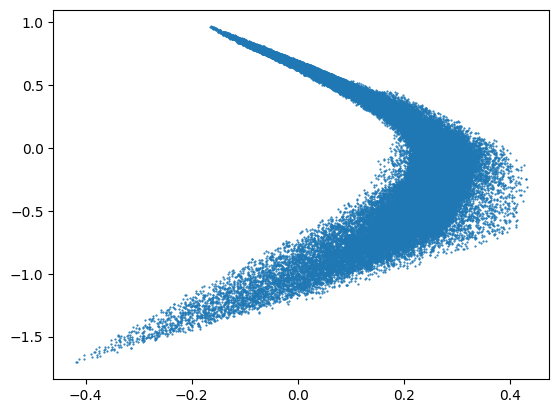

In [33]:
from IPython.display import clear_output

flag = True

while flag:

    idx1 = input("Input first index")
    try:
        idx1 = int(idx1)
    except:
        flag = False
        break
    idx2 = input("Input second index")
    try:
        idx2 = int(idx2)
    except:
        flag = False
        break
    clear_output()

    plt.scatter(emb_no_init_1[:, idx1], emb_no_init_1[:, idx2], s = 0.3)
    plt.show()

    